In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
#stoi = sorted(stoi)
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(f'{vocab_size=}')

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size=27


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            X.append(context)
            ix = stoi[ch]
            Y.append(ix)
            context = context[1:]+[ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
print(n1, n2)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

25626 28829
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn([vocab_size, n_embd], generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.01
b2 = torch.randn(vocab_size, generator=g)*0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [6]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    emb = C[Xb]
    embcat = emb.view(Xb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)


    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 100000: 3.3135
  10000/ 100000: 2.1648
  20000/ 100000: 2.3061
  30000/ 100000: 2.4541
  40000/ 100000: 1.9787
  50000/ 100000: 2.2930
  60000/ 100000: 2.4232
  70000/ 100000: 2.0680
  80000/ 100000: 2.3095
  90000/ 100000: 2.1207


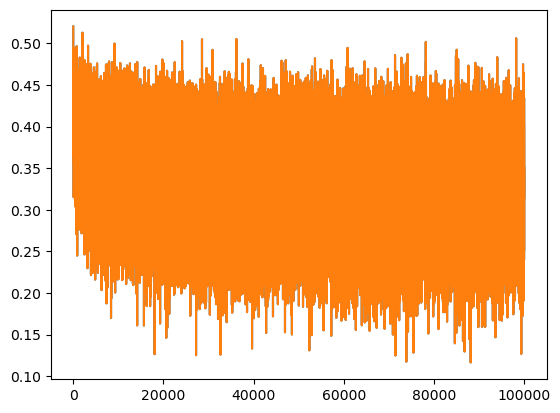

In [8]:
plt.plot(lossi)
plt.show()

In [9]:
@torch.no_grad()
def split_loss(split):
    x, y ={
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.127797842025757
val 2.178171396255493


In [32]:

    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

brysia.


In [33]:
lg = torch.randn(2,2)
print(lg)
torch.softmax(lg, dim=0)

tensor([[-1.4668, -0.8578],
        [-0.7699,  0.1676]])


tensor([[0.3325, 0.2640],
        [0.6675, 0.7360]])

In [129]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.dim = dim
        self.eps = eps
        self.momentum = momentum
        self.train = True
        
        self.gamma = torch.ones(self.dim)
        self.beta = torch.zeros(self.dim)
        
        self.running_mean = torch.zeros(self.dim)
        self.running_var = torch.ones(self.dim)

    def __call__(self, x):
        if self.train:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.train:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []



n_embd = 10
n_hidden = 100

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn([vocab_size, n_embd], generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47024


In [130]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

 # if i >= 1000:
 #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870
  10000/ 200000: 2.3273
  20000/ 200000: 2.1019
  30000/ 200000: 1.9020
  40000/ 200000: 2.1643
  50000/ 200000: 2.1520
  60000/ 200000: 1.7767
  70000/ 200000: 2.1514
  80000/ 200000: 2.3802
  90000/ 200000: 1.9338
 100000/ 200000: 2.3943
 110000/ 200000: 2.1508
 120000/ 200000: 2.1813
 130000/ 200000: 2.0889
 140000/ 200000: 1.8096
 150000/ 200000: 1.9132
 160000/ 200000: 1.9792
 170000/ 200000: 1.9654
 180000/ 200000: 2.2462
 190000/ 200000: 1.9601


In [124]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.train = False
split_loss('train')
split_loss('val')

train 3.282013416290283
val 3.281674861907959


In [101]:
print(layers[6].weight.std())
print(layers[1].running_mean)
print(layers[1].gamma)

tensor(0.1007, grad_fn=<StdBackward0>)
tensor([[-0.1013,  0.0491, -0.0500,  0.0252,  0.0026, -0.0313, -0.0648, -0.0362,
         -0.0775,  0.0153, -0.0449, -0.0460,  0.0565, -0.0042, -0.0157,  0.0627,
          0.0389, -0.0680,  0.0246,  0.0140,  0.0167, -0.0347,  0.0113,  0.0522,
          0.0178, -0.0033,  0.0631, -0.0290, -0.0366,  0.0327,  0.0186,  0.0026,
          0.0119, -0.0201, -0.0269, -0.0721, -0.0498, -0.0073, -0.0267, -0.0264,
         -0.0104,  0.0039,  0.0109, -0.0108, -0.0085, -0.0480, -0.0409, -0.0026,
          0.0148,  0.0323,  0.0620, -0.0203,  0.0072, -0.0184,  0.0270,  0.0115,
         -0.0046, -0.0344,  0.0139,  0.0128, -0.0118,  0.0212,  0.0263,  0.0039,
         -0.0257,  0.0074,  0.0270, -0.0046, -0.0397,  0.0115, -0.0041, -0.0045,
          0.0121, -0.0099, -0.0022,  0.0061,  0.0442, -0.0703, -0.0035, -0.0522,
          0.0115, -0.0189,  0.0115,  0.0697, -0.0511, -0.0308, -0.0280,  0.0341,
          0.0604, -0.0138,  0.0163,  0.0241,  0.0483,  0.0491, -0.0216

layer 2 (      Tanh): mean +0.01, std 0.70, saturated: 17.69%
layer 5 (      Tanh): mean -0.02, std 0.75, saturated: 21.62%
layer 8 (      Tanh): mean +0.01, std 0.78, saturated: 21.47%
layer 11 (      Tanh): mean +0.01, std 0.79, saturated: 23.25%
layer 14 (      Tanh): mean +0.02, std 0.81, saturated: 25.47%


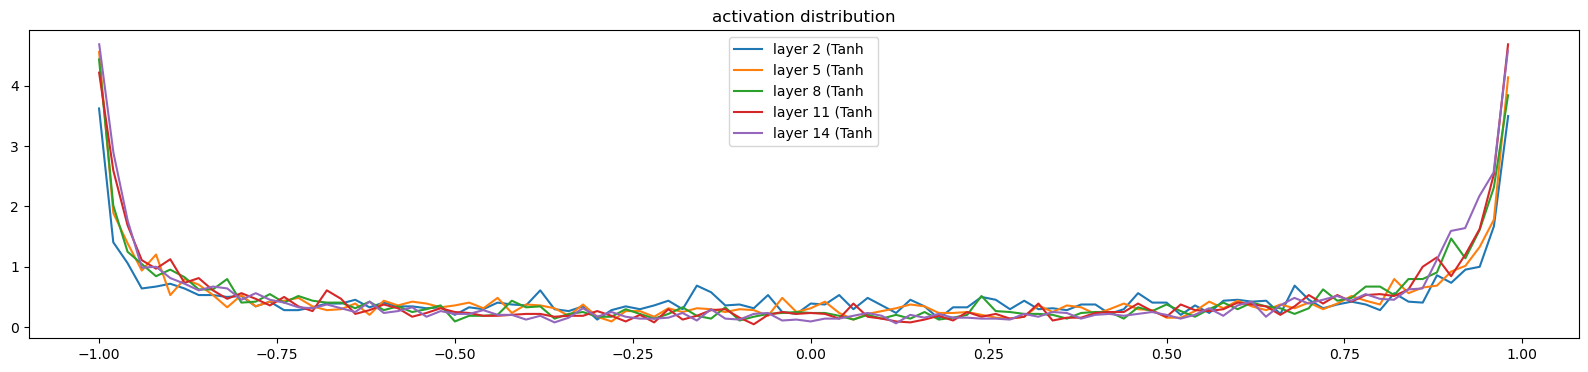

In [131]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

In [54]:
with torch.no_grad():
    g = torch.Generator().manual_seed(2147483647 + 10)
    
    for _ in range(40):
        out = []
        context = [0] * block_size
        while True:
            emb = C[torch.tensor([context])]
            x = emb.view(emb.shape[0], -1)
            for layer in layers:
                x = layer(x)
        
            logits = x
            probs = F.softmax(logits, dim=1)
        
            ix = torch.multinomial(probs, num_samples=1, generator=g).item() 
            context = context[1:] + [ix]
            out.append(ix)
        
            if ix == 0:
                break
    
        print(''.join(itos[i] for i in out))
    

cbrpzhxqtbfhqvkfkwmrpxqthtykhkcaqskejrzhnbnfqpwsyhc.
vgqeiunrzmuqptcmziivduxlhggphhbmgpoinfqdqjtzsrlivwa.
vvdbquwqjehogdjaryxixfkqeupiusdbwed.
ecxia.
gtlffhysflquhpqgmbvdjhksyjrpmqqosozswjcojqmwycjsfrenqkpfsadlnuo.
zoebsrkoiazhrynhr.
opklhynrxph.
xqioloqbprbvbbdn.
ipyqmuitjpbvfpzpddgpycsislqwkkmcrnzazqnljydpk.
kvweskatimzamdtevl.
ky.
qdyctoorowooktbymomokibfcw.
zoinhzcs.
nu.
eoaiunqqeroqci.
ipjzykbadyigluglc.
fwzyzdjokhnlhfzqsxmuadmtjhvtoyaplwuw.
xisxwrdfv.
zphtzbiuzzsrvgmknbfyntiysfgdglnmmj.
pqgcrvdhpvdafpsdvkhzkxkimtvoocjupgawjmjqjwgvhflwkewtxarclxdctpvhgqllyuil.
hhma.
gfcmmjpmubjbiygh.
rqkmxzkkiihknafslyfgevbayl.
g.
nfvtxlroookebrzneduajwxe.
pebyagvzxszznxfutytfzisxvepkmcmtdsszdtkwqfwwmiahizenpueayeaesdblkmmu.
a.
rbifiduvteaeasinhex.
gdxwutpoiwxymgnd.
gmbdbemlzopomjtbhthxyijxkxkj.
phqbtzhcttlfsraitxlxllamcacwtqxrypynxgazivagiwypefiyilhmesdbiqagitqssmdvlpkajspembyebymzfrewzsiwwlgiqgdoacd.
cfhnuekgxrdxgkd.
aeueoodrqsvgafadavqtwbasxeyp.
kdoeihnpuchtocebfrmhwdmwocgctgvftzbizzwbwxuzrpm.
